# Sensing Codebook Comparison

Comparison of LoneSTAR and CISSIR codebooks via range-angle maps.

Additional experiments:
* Alternative self-interference metrics (power sumn over beam pairs)
* CISSIR $\beta$ sweep
* Quantization noise statistics

## Setup

In [1]:
from IPython.display import display, Markdown

import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import windows as win
from scipy.interpolate import CubicSpline

# For link-level simulations
from sionna.channel import AWGN, ApplyOFDMChannel, time_to_ofdm_channel
from sionna.ofdm import OFDMModulator, OFDMDemodulator, ResourceGrid, ResourceGridMapper
from sionna.nr import CarrierConfig
from sionna.utils import QAMSource

from cissir.adc import max_abs_complex, quantize_signal, sqnr_bound
from cissir.beamforming import Beamspace, sionna_mimo_axes, steer_vec
from cissir.utils import plot_path, res_path
from cissir.raytracing import load_cir, load_si_paths, normalize_si_taps

from cissir import physics as phy, params, optimization as opt, visualization as viz
viz.paper_style()


In [2]:
# Global parameters

c = params.c
fc = params.fc_hz
wavelength_m = params.wavelength_m

ula_el_spacing = params.array_electrical_spacing

N_r = params.n_rx
N_t = params.n_tx

Q_bits = 6 # Each complex component (I and Q) is quantized with Q bits

In [3]:
## Waveform params

c_config = CarrierConfig(subcarrier_spacing=params.subcarrier_spacing_khz,
                         cyclic_prefix="normal")
num_subcarriers = params.num_prb * params.subcarriers_per_rb
subcarrier_spacing = params.subcarrier_spacing_khz * 1e3

Ts_sec = c_config.t_c
fft_size = round(1e-3/(c_config.subcarrier_spacing * Ts_sec))
cyclic_prefix_length = round(c_config.cyclic_prefix_length/Ts_sec)
digital_bw_hz = 1/Ts_sec

sig_bw_hz = num_subcarriers * subcarrier_spacing
sig_bw_frac = num_subcarriers/fft_size

t_channel_s = tf.range(cyclic_prefix_length, dtype=tf.float64) * Ts_sec
distance_m = phy.delay2distance(t_channel_s)

## OFDM configuration
num_ofdm_symbols = 1 # Number of OFDM symbols forming the resource grid
dc_null = True # Null the DC subcarrier
pilot_pattern = None # Pilot pattern
pilot_ofdm_symbol_indices = None # Index of OFDM symbols carrying pilots

null_carriers = fft_size - num_subcarriers
num_guard_carriers = [null_carriers//2, null_carriers//2] # Number of guard carriers on each side

rg = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                 fft_size = fft_size,
                 subcarrier_spacing = subcarrier_spacing,
                 num_tx = 1,
                 num_streams_per_tx = 1,
                 cyclic_prefix_length = cyclic_prefix_length,
                 dc_null = dc_null,
                 pilot_pattern = pilot_pattern,
                 pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                 num_guard_carriers = num_guard_carriers)

### Beam codebook


In [4]:
with np.load(res_path/"phased_cissir1tap_codebooks.npz") as cb_data:
    opt_si = cb_data["si_opt"]
    tgt_si = cb_data["si_tgt"]
    si_points = len(opt_si)
    
    opt_tx_codebooks = cb_data["tx"]
    L_t = opt_tx_codebooks.shape[-1]
    assert opt_tx_codebooks.shape == (si_points, N_t, L_t), "Unexpected shape for Tx codebook"
    opt_rx_codebooks = cb_data["rx"]
    L_r = opt_rx_codebooks.shape[-1]
    assert opt_rx_codebooks.shape == (si_points, N_r, L_r), "Unexpected shape for Tx codebook"

    tx_degs = cb_data["tx_degrees"]
    rx_degs = cb_data["rx_degrees"]
    beam_degs = tx_degs
    
    tx_codebook_p = opt_tx_codebooks[0,]
    rx_codebook_p = opt_rx_codebooks[0,]

In [5]:
with np.load(res_path/"phased_lonestar.npz") as lst_data:
    lst_tx_codebooks = lst_data["tx"][1:,]
    lst_rx_codebooks = lst_data["rx"][1:,]
    lst_points = lst_tx_codebooks.shape[0]


In [6]:
tx_cb_matrix = tf.cast(tx_codebook_p, dtype=tf.complex64)  # (N_t, L_t)
rx_cb_matrix = tf.cast(rx_codebook_p, dtype=tf.complex64)  # (N_r, L_r)

### Backscatter channels 

In [7]:
si_num_taps = 1 # "full"   # Options: 1, 2, "full"

ht_tgt, ht_si = load_cir('ht_tgt', 'ht_si', tf_type=tf.complex64)
t_rt = load_cir('t_channel_s', tf_type=None)

assert tf.math.reduce_all(tf.equal(t_rt, t_channel_s)), "Wrong assumed time scale from simulations"

t_arg = None
if isinstance(si_num_taps, int):
    h_si_paths, t_paths = load_si_paths(num_taps=si_num_taps)
    h_si_paths, _ = normalize_si_taps(h_si_paths, ht_si,
                                      tx_codebook_p, rx_codebook_p)
    t_arg = np.argmin(np.abs(t_rt - t_paths).squeeze(), axis=-1, keepdims=True)
    ht_si = np.zeros_like(ht_si)[:si_num_taps,]
    for i, ta in enumerate(t_arg):
        ht_si[i, ..., ta] = h_si_paths[i,].reshape(ht_si[i,..., ta].shape)
elif si_num_taps != "full":
    raise ValueError("Invalid SI tap option")
    
h_mimo = tf.concat([tf.reduce_sum(ht_si, axis=0, keepdims=True), ht_tgt], axis=0)
h_mimo.shape

TensorShape([2, 1, 8, 1, 8, 1, 2176])

Add 2nd target (virtually)

In [8]:
meter_init = 40.0
meter_new = 30.0
meter_shift = meter_new - meter_init
mag_scale = (meter_init/meter_new) ** 2 
sample_shift = tf.cast(tf.round(meter_shift/tf.reduce_mean(distance_m[1:]-distance_m[:-1])), tf.int32)
deg_shift = 60
rad_shift = np.deg2rad(deg_shift)
tx_shift = steer_vec(N_t, rad_shift)
rx_shift = steer_vec(N_r, rad_shift)
mimo_shift = tf.cast(tf.matmul(rx_shift, tx_shift, adjoint_b=True)[:, None, :, None, None], dtype=h_mimo.dtype)

h_tgt = h_mimo[-1,]
h_tgt += mimo_shift * mag_scale * tf.roll(h_tgt, sample_shift, axis=-1)
h_mimo = tf.stack([h_mimo[0,], h_tgt], axis=0)

In [9]:
# Beam forming
rx_axis, tx_axis = sionna_mimo_axes("ofdm")
opt_beamspace = Beamspace(receive_axis=rx_axis, transmit_axis=tx_axis)
h_siso = opt_beamspace([h_mimo, rx_cb_matrix, tx_cb_matrix])
h_beamspace = tf.squeeze(h_siso, axis=(1, 3, 5))
h_beams = tf.linalg.diag_part(tf.transpose(h_beamspace, perm=[0, 3, 1, 2]))

In [10]:
l_max = tf.argmax(tf.reduce_max(tf.abs(h_beams[-1,]), axis=0))
t_argmax = tf.argmax(tf.reduce_max(tf.abs(h_beams[-1,]), axis=1))
dist_tgt = distance_m[t_argmax]
az_tgt = beam_degs[l_max]
dist_max = dist_tgt + 5
print(f"Target located at {dist_max:.1f} m, {az_tgt:.1f}°")

Target located at 44.7 m, -38.7°


In [11]:
bslice = slice(l_max-1,None,8)
b_max = 0
hyb_degs = beam_degs[bslice]
num_beams = len(hyb_degs)
print(f"Beams point at {np.round(hyb_degs, 1)} degrees")

rg_hyb = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                      fft_size = fft_size,
                      subcarrier_spacing = subcarrier_spacing,
                      num_tx = 1,
                      num_streams_per_tx = num_beams,
                      cyclic_prefix_length = cyclic_prefix_length,
                      dc_null = dc_null,
                      pilot_pattern = pilot_pattern,
                      pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                      num_guard_carriers = num_guard_carriers)

Beams point at [-43.4 -10.8  18.2  54.3] degrees


In [12]:
hsi_csr = []
hsi_mimo = tf.reduce_sum(h_mimo[:-1,], axis=0, keepdims=True)
for i in range(si_points):
    tx_cb_vec = tf.cast(opt_tx_codebooks[i,], dtype=tf.complex64)
    rx_cb_vec = tf.cast(opt_rx_codebooks[i,], dtype=tf.complex64)
    h_siso = opt_beamspace([hsi_mimo, rx_cb_vec, tx_cb_vec])
    h_b = tf.squeeze(h_siso) #, axis=(1, 3, 5))
    hsi_csr.append(h_b)
hsi_csr = np.stack(hsi_csr, axis=0)

In [13]:
csr_si_beams = np.sum(np.abs(hsi_csr), axis=-1)
csr_powsum = phy.pow2db(np.sum(csr_si_beams**2, axis=(1,2)))
csr_maxsi = np.max(phy.mag2db(csr_si_beams), axis=(1,2))

csr_txdev = np.linalg.norm(opt_tx_codebooks - tx_codebook_p, axis=-2, ord=2)
csr_rxdev = np.linalg.norm(opt_rx_codebooks - rx_codebook_p, axis=-2, ord=2)
csr_rxcb = phy.pow2db(np.mean(csr_rxdev**2, axis=-1)+1e-4)
csr_txcb = phy.pow2db(np.mean(csr_txdev**2, axis=-1)+1e-4)


In [14]:
hsi_ls= []
for i in range(lst_points):
    tx_cb_vec = tf.cast(lst_tx_codebooks[i,], dtype=tf.complex64)
    rx_cb_vec = tf.cast(lst_rx_codebooks[i,], dtype=tf.complex64)
    h_siso = opt_beamspace([hsi_mimo, rx_cb_vec, tx_cb_vec])
    h_b = tf.squeeze(h_siso) #, axis=(1, 3, 5))
    hsi_ls.append(h_b)
hsi_ls = np.stack(hsi_ls, axis=0)

In [15]:
lst_si_beams = np.sum(np.abs(hsi_ls), axis=-1)
lst_powsum = phy.pow2db(np.sum(lst_si_beams**2, axis=(1,2)))
lst_maxsi = np.max(phy.mag2db(lst_si_beams), axis=(1,2))

lst_txdev = np.linalg.norm(lst_tx_codebooks - tx_codebook_p, axis=-2, ord=2)
lst_rxdev = np.linalg.norm(lst_rx_codebooks - rx_codebook_p, axis=-2, ord=2)
lst_txcb = phy.pow2db(np.mean(lst_txdev**2, axis=-1)+1e-4)


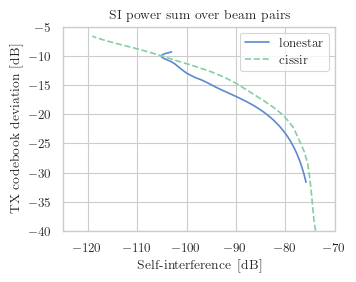

In [16]:
plt.plot(lst_powsum - phy.pow2db(L_r*L_t), lst_txcb, label="lonestar")
plt.plot(csr_powsum - phy.pow2db(L_r*L_t), csr_txcb, label="cissir")
plt.xlim(-125, -70)
plt.ylim(-40, -5)
plt.legend()
plt.xlabel("Self-interference [dB]")
plt.ylabel("TX codebook deviation [dB]")
plt.title("SI power sum over beam pairs")
plt.show()

In [17]:
msi, rxdev, txdev = csr_maxsi, csr_rxdev, csr_txdev
len_csr = len(msi)
b_maxsshift = len_csr - 1
b_shifts = np.arange(-b_maxsshift, b_maxsshift + 1, 2)
b_shift_mat = np.empty((len(b_shifts), len_csr))
b_shift_mat[:] = np.nan
i_center = len_csr // 2 + 1

for i, b in enumerate(b_shifts):
    if b < 0:
        csr_jnt_dev = phy.pow2db(np.mean(((1 - txdev[:b,]) * (1-rxdev[-b:,]))**2, axis=-1))
        b_shift_mat[i, -b//2:b//2] = csr_jnt_dev
    elif b > 0:
        csr_jnt_dev = phy.pow2db(np.mean(((1-txdev[b:,]) * (1-rxdev[:-b,]))**2, axis=-1))
        b_shift_mat[i, b//2:-b//2] = csr_jnt_dev
    else:
        csr_jnt_dev = phy.pow2db(np.mean(((1-txdev) * (1-rxdev))**2, axis=-1))
        b_shift_mat[i, :] = csr_jnt_dev
        

In [18]:
msi_shift_db = 1.0
beta = (msi_shift_db * b_shifts)/2 +1

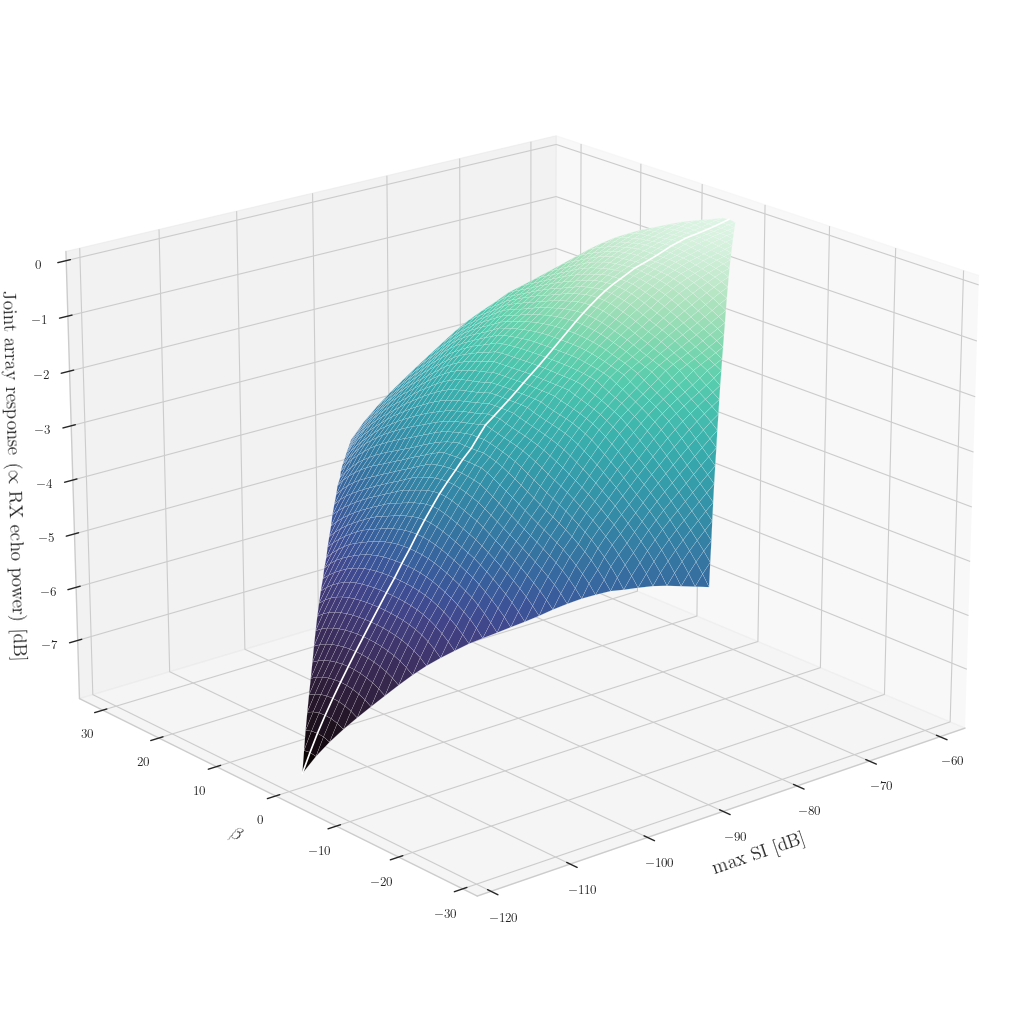

In [19]:
extent = (msi[0], msi[-1], beta[0], beta[-1])

x, y = np.meshgrid(msi, beta)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10, 10), layout="constrained")

surf = ax.plot_surface(x, y, b_shift_mat, rstride=1, cstride=1, cmap="mako", #vmax=0, vmin=-6,
                       linewidth=0.1,)
line = ax.plot(msi, b_shift_mat[len(b_shifts)//2,:], "-w", zs=1, zdir='y')

ax.view_init(elev=20, azim=-130)
ax.set_xlabel("max SI [dB]", fontsize="x-large")
ax.set_ylabel(r"$\beta$", fontsize="x-large")
_ = ax.set_zlabel(r"Joint array response ($\propto$ RX echo power) [dB]", fontsize="x-large")

In [20]:
hf_list = []
opt_tx_beam = opt_tx_codebooks[..., l_max:l_max+1]
opt_rx_beam = opt_rx_codebooks[..., l_max:l_max+1]
for i in range(si_points):
    tx_cb_vec = tf.cast(opt_tx_beam[i,], dtype=tf.complex64)
    rx_cb_vec = tf.cast(opt_rx_beam[i,], dtype=tf.complex64)
    h_siso = opt_beamspace([h_mimo, rx_cb_vec, tx_cb_vec])
    h_b = tf.squeeze(h_siso, axis=(1, 3, 5))
    h_b = tf.transpose(h_b, perm=[0, 3, 1, 2])
    h_b = tf.linalg.diag_part(h_b)
    ht_ = h_b[..., 0]

    hfreq = time_to_ofdm_channel(tf.reshape(ht_, shape=(1, ht_.shape[0], 1, 1, 1, 1, ht_.shape[-1])) * 
                             tf.ones(shape=(1, 1, 1, 1, 1, fft_size+cyclic_prefix_length, ht_.shape[-1]),
                                     dtype=ht_.dtype), rg, l_min=0)
    hf_list.append(hfreq)

hfreq_opt = tf.stack(hf_list, axis=0)

In [21]:
si_beam = []
tx_dev = []
h_si_beam = np.squeeze(np.sum(ht_si, axis=0)).transpose(2, 0, 1)
tx_ref = opt_tx_beam[0]
for i in range(si_points):
    si_b = opt.codebook_si(opt_tx_beam[i], opt_rx_beam[i,], h_si_beam)
    si_beam.append(phy.mag2db(np.max(si_b)))
    tx_d = opt.codebook_deviation_power(opt_tx_beam[i], tx_ref)
    tx_dev.append(phy.pow2db(max(tx_d, 1e-10)))

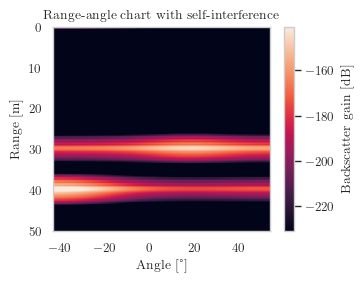

In [22]:
min_dist_m = 0
max_dist_m = 50

dr_db = 90

h_beams_db = phy.mag2db(tf.abs(np.sum(h_beams, axis=0)) + 1e-20)

vmax = np.quantile(h_beams_db, 0.998)
vmin = vmax - dr_db

extent = (min(hyb_degs), max(hyb_degs), min(distance_m), max(distance_m))
plt.imshow(h_beams_db[..., bslice], vmin=vmin, vmax=vmax, interpolation='bicubic',
           origin='lower', extent=extent, aspect="auto"),
plt.xlabel("Angle [°]")
plt.ylabel("Range [m]")
plt.xlim(extent[1], extent[0])
plt.ylim(min_dist_m, max_dist_m)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.grid(visible=False)
cbar = plt.colorbar()
cbar.set_label("Backscatter gain [dB]")
_ = plt.title("Range-angle chart with self-interference")

In [23]:
ht = h_beamspace[..., l_max, l_max, :]

In [24]:
hr1 = tf.abs(tf.norm(ht[-1,], ord=1))
hr2 = tf.abs(tf.norm(ht[-1,], ord=2))
hs1_init = tf.abs(tf.norm(ht[0,], ord=1))
t_vec = t_channel_s * 1e6

## Simulations

In [25]:
symbol_energy = 1.0
noise_power = params.n0 * sig_bw_hz # mW
ch_gain = hr2**2/sig_bw_frac
noise_dbm = phy.pow2db(noise_power)
channel_db = phy.pow2db(ch_gain)
si_db_init = phy.mag2db(hs1_init)

pt_dbm = 30
papr_ref = 2.0 

snr_th_db = pt_dbm + phy.pow2db(ch_gain) - noise_dbm

link_display = ["### Link budget summary\n", f"| Parameter | Value | Unit | Condition |",
                f"| --------- | -----: | ---- | ---------: |", f"| $P_t$ level | {pt_dbm} | dBm | |",
                f"| SI gain | {si_db_init:.1f} | dB | |", f"| Channel gain | {channel_db:.1f} | dB | |",
                f"| Noise power | {noise_dbm:.1f} | dBm | |",
                f"| Thermal SNR | {snr_th_db:.1f} | dB | $P_t$={pt_dbm} dBm |"]

channel_db = phy.mag2db(hr1)
sqnr_db = phy.pow2db(sqnr_bound(si_db_init - channel_db, hr1, hr2,
                                Q_bits, papr_ref, 1.0, sig_bw_frac, None))
link_display.append(f"| ADC SNR | {sqnr_db:.1f} | dB | PAPR={phy.pow2db(papr_ref):.1f} dB |")
display(Markdown("\n".join(link_display)))

si_values = np.arange(10 * round(channel_db/10) + 10, si_db_init + 20, 3.5)

        # {"waveform_name": (bits_per_symbol, dft_spread), ...}
wf_dict = {"QPSK SC-FDM": (2, True),
           "64QAM  OFDM": (6, False)}

waveforms = tuple(wf_dict.keys())

trials = 1000

### Link budget summary

| Parameter | Value | Unit | Condition |
| --------- | -----: | ---- | ---------: |
| $P_t$ level | 30 | dBm | |
| SI gain | -66.6 | dB | |
| Channel gain | -111.0 | dB | |
| Noise power | -90.8 | dBm | |
| Thermal SNR | 9.8 | dB | $P_t$=30 dBm |
| ADC SNR | -9.6 | dB | PAPR=3.0 dB |

In [26]:
si_min, si_max = -106, -59

si_index = np.arange(len(tgt_si))[np.logical_and(si_min < opt_si, opt_si < si_max)]
ofdm_channel = ApplyOFDMChannel(add_awgn=False)
awgn = AWGN()

In [27]:
si_ref_vals = [-50, -81]
ref_i, csr_i = (np.argmin(np.abs(tgt_si - si_r)) for si_r in si_ref_vals)
lst_i = np.argmin(np.abs(lst_txcb - csr_txcb[csr_i]))
si_ref_lst = lst_maxsi[lst_i]

In [28]:
si_indices = [np.argmin(np.abs(tgt_si - si_r)) for si_r in si_ref_vals]

num_bits_per_symbol, dft_spread = wf_dict[waveforms[-1]]
num_symbols = 1

si_est_db = [tgt_si[i] for i in si_indices]
txdev = [csr_txcb[i] for i in si_indices]
txdev.insert(1, lst_txcb[lst_i])
si_est_db.insert(1, si_ref_lst)
ht_est_lvls = []
snr_db = []
noise_db = []
noise_samples = []
noise_var = []
quant_var = []
y_noise_var = []

labels=[f"{si_est_db[0]:.1f} dB (Reference)",
        f"{si_est_db[1]:.1f} dB (LoneSTAR)",
        f"{si_est_db[2]:.1f} dB (CISSIR)",
        f"Ground truth"]

spec_win = np.pad(win.hann(num_subcarriers, sym=False), num_guard_carriers, constant_values=0).astype(np.complex256)


g_t = np.sqrt(phy.db2power(pt_dbm) / (symbol_energy * sig_bw_frac))

# Modulation order 
qam_source = QAMSource(num_bits_per_symbol =  num_bits_per_symbol) 

# symbols onto an OFDM resource grid
hyb_mapper = ResourceGridMapper(rg_hyb)

# OFDM mod/demod: freq --> time
l_min = 0
modulator = OFDMModulator(rg_hyb.cyclic_prefix_length)
demodulator = OFDMDemodulator(rg_hyb.fft_size, l_min, rg_hyb.cyclic_prefix_length)

db_shift = tf.concat([tf.ones_like(h_mimo[:1,]) * phy.db2mag(s) for s in (0, -6)], axis=0)
h_mimo_ = h_mimo * db_shift

si_mask = np.zeros(shape=h_mimo.shape)
for i_t in t_arg:
    si_mask[0,..., i_t] = 1
si_mask = tf.cast(si_mask, dtype=h_mimo.dtype)

for rx_beams, tx_beams, si_present in [(opt_rx_codebooks[ref_i,], opt_tx_codebooks[ref_i,], True),
                                       (lst_rx_codebooks[lst_i], lst_tx_codebooks[lst_i], True),
                                       (opt_rx_codebooks[csr_i,], opt_tx_codebooks[csr_i,], True),
                                       (opt_rx_codebooks[ref_i,], opt_tx_codebooks[ref_i,], False)]:

    tx_cb_vec = tf.cast(tx_beams[..., bslice], dtype=tf.complex64)
    rx_cb_vec = tf.cast(rx_beams[..., bslice], dtype=tf.complex64)

    if not si_present:
        h_mimo_ *= tf.concat([tf.zeros_like(hsi_mimo), tf.ones_like(hsi_mimo)], axis=0)    
    
    h_hyb = tf.squeeze(opt_beamspace([h_mimo_, rx_cb_vec, tx_cb_vec]), axis=(1, 3, 5))
    t_shape = (1, h_hyb.shape[0], h_hyb.shape[1], 1, h_hyb.shape[2], 1, h_hyb.shape[3])
    t_steps = tf.ones(shape=(1, 1, 1, 1, 1, fft_size + cyclic_prefix_length, 1), dtype=h_hyb.dtype)

    hf = time_to_ofdm_channel(tf.reshape(h_hyb, shape=t_shape) * t_steps, rg, l_min=0)
    
    # Binary source + QAM mapper block 
    x_symbols = qam_source([num_symbols, 1, num_beams, rg_hyb.num_data_symbols])
    
    # Resource grid mapper block 
    x_rg = g_t * hyb_mapper(x_symbols)
    x_t = modulator(x_rg)
    
    y_freq = ofdm_channel([x_rg, tf.cast(hf, dtype=x_rg.dtype)])
    ysi_freq = y_freq[:,:-1,]
     
    y_time = modulator(y_freq)
    y_si = y_time[:, :-1,]
    y_r = y_time[:,-1:,]
    y_t = y_r + y_si
    y_n = awgn([y_t, noise_power])
    max_yn = max_abs_complex(y_n, keepdims=True, axis=tf.range(y_t.ndim)) # axis=tf.range(1, y_t.ndim), 

    if si_present:
        yn_quant = quantize_signal(y_n, max_value=max_yn, quantization_bits=Q_bits)
        var_q = (2/3)*max_yn**2*np.power(2.0,-2*Q_bits)
    else:
        var_q = 0
        yn_quant = y_n

    quant_var.append(noise_power + float(var_q))

    n_t = yn_quant - y_t
    
    pow_yr = tf.math.reduce_variance(y_r[..., b_max:b_max+1, :])
    pow_noise = tf.math.reduce_variance(n_t[..., b_max:b_max+1, :])
    noise_db.append(phy.pow2db(pow_noise))
    snr_db.append(phy.pow2db(pow_yr) - noise_db[-1])
    
    # Frequency-domain matched filter

    x_win = np.conj(x_rg).astype(np.complex256) * spec_win
    yn_freq = demodulator(yn_quant)
    h_est_freq = (yn_freq - ysi_freq) * x_win
    ht_est = np.fft.ifft(np.fft.ifftshift(h_est_freq, axes=-1), axis=-1)[..., :cyclic_prefix_length] #* dr_boost
    ht_est = ht_est.reshape(-1, num_beams, cyclic_prefix_length).mean(axis=0)

    ht_est_lvls.append(ht_est)

    # Noise stats

    n_freq = demodulator(n_t)
    noise_mf_freq = n_freq * x_win
    noise_mf_t = np.fft.ifft(np.fft.ifftshift(noise_mf_freq, axes=-1), axis=-1) #* dr_boost
    noise_samples.append(np.reshape(noise_mf_t, -1))
    
    x_win_t = np.fft.ifft(np.fft.ifftshift(x_win, axes=-1), axis=-1)
    noise_var.append((noise_power+float(var_q))*np.mean(np.abs(x_win_t)**2))
    y_noise_var.append(pow_noise)
   
print("Estimated SNR:")
print("\t".join([f"{s:.1f} dB" for s in snr_db]))
print("Estimated noise:")
print("\t".join([f"{n:.1f} dB" for n in noise_db]))

Estimated SNR:
-30.8 dB	-20.9 dB	-14.8 dB	2.8 dB
Estimated noise:
-57.0 dB	-67.5 dB	-73.7 dB	-90.8 dB


[-40.0, -18.20065786292785, -18.305997439516922]
-69.9 dB (LoneSTAR)
-80.6 dB (CISSIR)
Ground truth


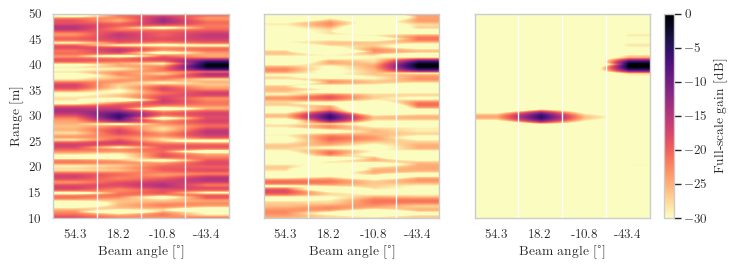

In [29]:
min_dist_m = 10
max_dist_m = 50

distance_mask = np.logical_and(min_dist_m <= distance_m, distance_m <= max_dist_m)

dr_db = 30


x_degs = hyb_degs
cs = CubicSpline(hyb_degs, ht_est_lvls, axis=1)
ht_est_db = phy.mag2db(tf.abs(ht_est_lvls))[..., distance_mask]
ht_est_db -= np.max(ht_est_db[1:])

vmax = 0
vmin = vmax - dr_db

extent = (1, len(hyb_degs)*2+1, min_dist_m, max_dist_m)

fig, axes = plt.subplots(1, 3, figsize=(viz.def_figsize[0]*2.5, viz.def_figsize[1]))

print(txdev)
for i, hb in enumerate(ht_est_db[1:]):
    plt.sca(axes[i])
    im = plt.imshow(hb.T, vmin=vmin, vmax=vmax, cmap="magma_r", interpolation='bilinear',
               origin='lower', extent=extent, aspect="auto")
    plt.xlabel("Beam angle [°]")
    plt.xticks(np.arange(2, num_beams*2+1, 2), np.round(hyb_degs, 1))
    if i == 0:
        plt.ylabel("Range [m]")
    else:
        axes[i].yaxis.set_visible(False)
    plt.xlim(extent[1], extent[0])
    plt.grid(visible=False)
    print(labels[i+1])
    
    if i == len(ht_est_db)-2:
        cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.1, pad=0.02)
        cbar.set_label("Full-scale gain [dB]")
    for j in range(3,num_beams*2,2):
        plt.plot([j, j], [min_dist_m, max_dist_m], "-", color='w', linewidth=1.0)

In [30]:
viz.save(fig, "range_angle", save_format="pgf")

for i, ax in enumerate(axes):
    bbxtra = [fig.axes[-1]] if i == 2 else None
    for ax_i in axes:
        ax_i.set_visible(ax_i == ax)
    extent = ax.get_tightbbox(bbox_extra_artists=bbxtra).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(plot_path/f"ra{i+1}.pdf", bbox_inches=extent)
    fig.savefig(plot_path/f"ra{i+1}.pgf", bbox_inches=extent)

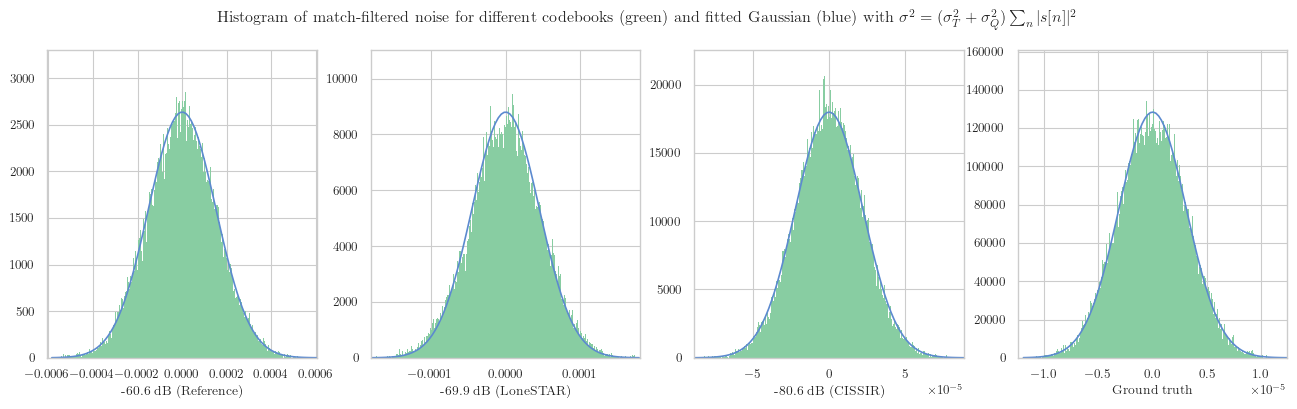

In [31]:
len_n = len(noise_samples)
fig, axes = plt.subplots(1, len_n, figsize=(16,len_n))
for i, ns_vec in enumerate(noise_samples):
    ax = axes[i]
    ns_real = np.concatenate([np.real(ns_vec), np.imag(ns_vec)])
    ax.hist(ns_real, bins=1000, linewidth=0, density=True, color=viz.g)
    n_std = np.sqrt(noise_var[i]/2)
    n_mu = 0
    n_min, n_max = np.min(ns_real), np.max(ns_real)
    n_x = np.linspace(n_min, n_max, 100)
    ax.plot(n_x, np.exp(-(n_x-n_mu)**2/(2*n_std**2))/(n_std*np.sqrt(2*np.pi)), viz.b, linestyle="-")
    ax.set_xlim(-4*n_std, 4*n_std)
    ax.set_ylim(0, 0.5/n_std)
    ax.set_xlabel(labels[i])
_ = fig.suptitle(r"Histogram of match-filtered noise for different codebooks (green) and fitted Gaussian (blue) with "+
                 r"$\sigma^2=(\sigma^2_T+\sigma^2_Q)\sum_n|s[n]|^2$")